In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
import tensorflow as tf
import random
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm

import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score




2024-09-10 13:51:41.417455: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 13:51:41.417601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 13:51:41.570773: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('../input/amirkabirdam/dam12.csv')
df.head(2)

,DamId,DateRow,Torbin_out,TakhlieAbgir_out,Sarriz_out,TabKhir_out,Total_out,TotalMasraf_out,TakhlieRosob_out,Cheshme_out,...,NamNesbi6_5,NamNesbi12_5,NamNesbi18_5,TolGeo,ArzGeo,MaxErtefaAzDarya,MinErtefaAzDarya,KafDaryache,GonjayeshKolMakhzan,GonjayeshMofidMakhzan
0,1,1966-05-11,1.63296,0.0,0.0,0.0,1.63296,0.22464,0,0,...,0.0,0.0,0.0,54.25563,35.252621,1765,1600,1595,183,177.3
1,1,1970-10-08,0.78624,0.0,0.0,0.0,0.78624,0.45792,0,0,...,0.0,0.0,0.0,54.25563,35.252621,1765,1600,1595,183,177.3


In [3]:
df['humidity']=df[['NamNesbi6_5', 'NamNesbi12_5','NamNesbi18_5']].mean(axis=1)
df['daraje']= df[['MinDarajehararat_in','MaxDarajehararat_in']].mean(axis=1)

In [4]:
df['DateRow'] = pd.to_datetime(df['DateRow'])
df = df.sort_values(by= 'DateRow')
df = df[df['DateRow']>'2015']


In [5]:
target = 'Total_in'
features = ['Barandegi_in','TotalAbBarfVBaran_in','DebiSeilabm3c','daraje','VazeHava_in','SoratBad_in' ,'humidity']
#'t1/t2','Total_in364','Total_in7','Total_in30',,'Barandegi_in7','Barandegi_in364'
      #      ,'Barandegi_in30','daraje7','daraje30'
      #      ,'daraje364','rolling_mean_30','rolling_std_30','rolling_mean_364','rolling_std_364','Total_in-6'
#'Total_in1','rolling_mean_7','rolling_std_7',,'Barandegi_in1','daraje1','Total_in2'
df1= df[features + [target]]

In [6]:
cal=['year','month','day_of_week','day_of_year']

df['year'] = df['DateRow'].dt.year
df['month'] = df['DateRow'].dt.month
df['day_of_week'] = df['DateRow'].dt.dayofweek
df['day_of_year'] = df['DateRow'].dt.dayofyear
df.drop(columns=['DateRow'], inplace=True)

In [7]:
shift=[1,2,7,30,90,365]
temp=pd.DataFrame()
def create_shifted_dataframe(df, column_name, shift_period):
    shifted_column = df[column_name].shift(periods=shift_period)
    r_column_m= df[column_name].shift(periods=1).rolling(window=shift_period).mean()
    shift_df = pd.DataFrame({f"{column_name}_{shift_period}": shifted_column})
    roll_df = pd.DataFrame({f"{column_name}_{shift_period}": r_column_m})
    return (shift_df,roll_df)

for i in range (len (shift)):
    for j in range(len (df[features + [target]].columns)):
        temp[df1.columns[j]+'_rm_'+str(shift[i])],temp[df1.columns[j]+str(shift[i])] = (create_shifted_dataframe(df1,df1.columns[j], shift[i]))

final=pd.concat([df1,temp, df[cal]], axis=1)        

df['Total_in1']=df['Total_in'].shift(1)
df['Total_in2']=df['Total_in'].shift(2)
df['t1/t2']= df['Total_in1']/df['Total_in2']
df['Total_in-6']= df['Total_in'].shift(-6)
df['Total_in7']=df['Total_in'].shift(7)

df['Total_in30']= df['Total_in'].shift(30)
df['Total_in364']=df['Total_in'].shift(364)

#df['Barandegi_in1']=df['Barandegi_in'].shift(1)
df['Barandegi_in7']=df['Barandegi_in'].shift(7)
df['Barandegi_in30']=df['Barandegi_in'].shift(30)
df['Barandegi_in364']=df['Barandegi_in'].shift(364)

#df['daraje1']=df['daraje'].shift(1)
df['daraje7']=df['daraje'].shift(7)
df['daraje30']=df['daraje'].shift(30)
df['daraje364']=df['daraje'].shift(364)

#df['rolling_mean_7'] = df['Total_in'].shift(1).rolling(window=7).mean()
#df['rolling_std_7'] = df['Total_in'].shift(1).rolling(window=7).std()
df['rolling_mean_30'] = df['Total_in'].shift(7).rolling(window=30).mean()
df['rolling_std_30'] = df['Total_in'].shift(7).rolling(window=30).std()
df['rolling_mean_364'] = df['Total_in'].shift(364).rolling(window=364).mean()
df['rolling_std_364'] = df['Total_in'].shift(364).rolling(window=364).std()

In [8]:

y=final[target]

x = final. drop(target,axis=1)

In [9]:
tscv = TimeSeriesSplit(n_splits = 10)
test_rmse = []
train_rmse= []
test_r2 = []
train_r2=[]
i=0
for train_index, test_index in tscv.split(x):
    i+=1
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    if i>=6:
        
        model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.01,  max_depth= 9, colsample_bytree= 0.6)
        
        model.fit(X_train,Y_train)

    # Predictions
        test_predict = model.predict(X_test)
        train_predict = model.predict(X_train)
        
        test_rmse.append ( np.sqrt(mean_squared_error(Y_test, test_predict)))
        train_rmse.append ( np.sqrt(mean_squared_error(Y_train, train_predict)))
        
        test_r2 .append ( r2_score(Y_test, test_predict))
        train_r2 .append ( r2_score(Y_train, train_predict))
        
print("rmsetrain:",np.mean(train_rmse),"rmsetest",np.mean(test_rmse))
print ("r2train:",np.mean(train_r2),'r2test:',np.mean(test_r2) )





rmsetrain: 0.22487290771766447 rmsetest 0.25405173038994217
r2train: 0.965858693176715 r2test: 0.8832021795874029


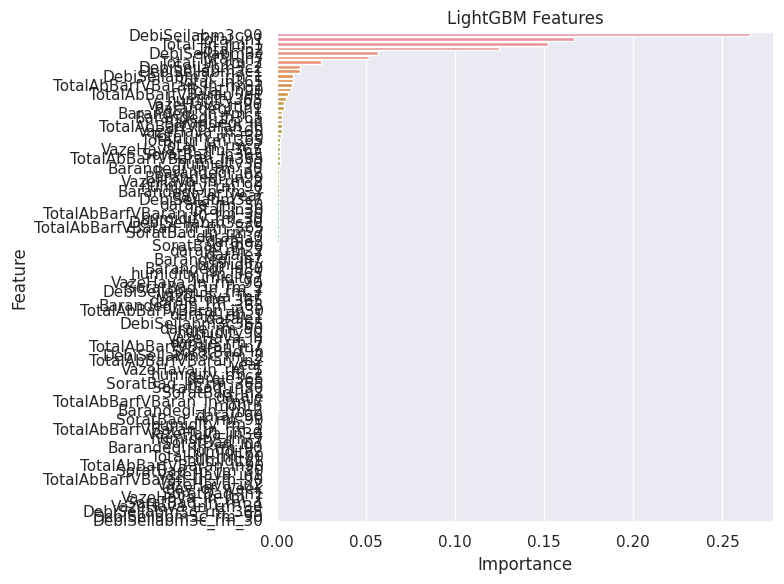

In [10]:

imp = pd.DataFrame({'Importance':model.feature_importances_,'Feature':x.columns})
plt.figure(figsize=(8, 6))
sns.set(font_scale = 1)
sns.barplot(x="Importance", y="Feature", data=imp.sort_values(by="Importance", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [11]:

imp = pd.DataFrame({'Importance':model.feature_importances_,'Feature':x.columns})
fe=imp.sort_values(by='Importance',ascending=False).head(30)
fe.head(30)

,Importance,Feature
76,0.265647,DebiSeilabm3c90
22,0.166778,Total_in1
21,0.152388,Total_in_rm_1
38,0.124797,Total_in2
2,0.056581,DebiSeilabm3c
54,0.051554,Total_in7
37,0.024635,Total_in_rm_2
28,0.013048,DebiSeilabm3c2
12,0.012947,DebiSeilabm3c1
11,0.008995,DebiSeilabm3c_rm_1
